<a href="https://colab.research.google.com/github/pradyot-09/Thesis/blob/master/code/Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reverse Weighted Dispersion Entropy (RWDE)

Install Python entropy library


In [ ]:
!git clone https://github.com/raphaelvallat/entropy.git
%cd entropy
!pip install -r requirements.txt
!python setup.py develop

In [54]:
!pip install -U UliEngineering

Requirement already up-to-date: UliEngineering in /usr/local/lib/python3.6/dist-packages (0.3.5)


## Entropy Implementations
We first implement the following entropy methods for later comparison with our method (RWDE):

1. Permutation Entropy (PE from entropy library)
2. Weighted Permutation Entropy (WPE)
3. Reverse Permutation Entropy (RPE)
4. Dispersion Entropy (DE)
5. Reverse Dispersion Entropy (RDE)
6. Reverse Weighted Dispersion Entropy (RWDE)



In [55]:
from scipy.stats import norm
from entropy import *
import numpy as np
import matplotlib.pyplot as plt
import math

# function to calculate variance of each subsequence
def cal_weights(values):
  sum = 0
  avg = np.mean(values)
  for w in values:
    sum = sum + (w-avg)**2
  return sum/len(values)

#function to calculate weight of each permutation
def cal_weighted_permutations(weights,permutation_indexes):
  weighted_permutations = np.zeros(len(permutation_indexes)) 
  for i,indexes in enumerate(permutation_indexes):
    weighted_permutations[i] =  weights[indexes].sum()
  return weighted_permutations/weighted_permutations.sum()

# function to calculate weights of permutation
def get_weights(values,order): 
  permutations = np.array([values[i : i + order] for i in range(len(values) - order + 1)])
  weights = list(map(cal_weights,permutations))
  return weights

# function to convert the time series in normal distribution
def get_ncdf_values(values,classes):
  norm_values = norm.cdf(values,loc=np.mean(values),scale=np.std(values))
  mapped_values = np.array([round(classes*i + 0.5) for i in norm_values])
  return mapped_values

# function to convert array of permutations to string
def get_str_permutation(mapped_values,order):
  mapped_permutations = np.array([mapped_values[i : i + order] for i in range(len(mapped_values) - order + 1)])
  str_permutations = list(map(str,mapped_permutations))
  return str_permutations

# function to convert array of permutations to string for ordinal entropies
def get_str_permutation_ordinal(mapped_values,order):
  mapped_permutations = np.array([np.argsort(mapped_values[i : i + order]) for i in range(len(mapped_values) - order + 1)])
  str_permutations = list(map(str,mapped_permutations))
  return str_permutations  

# returns all indexes of occurrences of a permutation
def get_permutation_index(str_permutations):
  permutation_indexes = []
  for perm in set(str_permutations):
    #print(perm)
    indexes = [i for i, e in enumerate(str_permutations) if e == perm]
    permutation_indexes.append(indexes) 
  return permutation_indexes

# return the probabilty/weight of a permutation
def get_permutation_frequency(permutation_indexes,length,order):
  permutation_frequency = np.zeros(len(permutation_indexes)) 
  for i,indexes in enumerate(permutation_indexes):
    permutation_frequency[i] =  len(indexes)
  return permutation_frequency/(length-order+1)

# returns shanon entropy of given array of permutation frequency
def get_shanon_entropy(permutation_frequency):
  entropy = 0
  for freq in permutation_frequency:
    entropy = entropy + freq*math.log2(freq)

  return -entropy 

# Reverse weighted Dispersion Entropy
def RWDE(values,order,classes,normalize=True):
  # find variance of each permutation
  weights = get_weights(values,order)
  # convert values with NCDF and assign them class
  mapped_values = get_ncdf_values(values,classes)
  # get all the permuations
  str_permutations = get_str_permutation(mapped_values,order)
  
  #find the indices of a permutation
  permutation_indexes = get_permutation_index(str_permutations)
  
  # get the weight for each permutation
  weighted_permutations = cal_weighted_permutations(np.array(weights),permutation_indexes)
  
  entropy = np.square(weighted_permutations).sum() - (1/(classes**order))
  # calculate final RWDE entropy
  if normalize:
    entropy = entropy/(1 - (1/(classes**order)))
   
  return entropy

# Dispersion Entropy
def DE(values,order,classes,normalize=True):
  mapped_values = get_ncdf_values(values,classes)
  # get all the permuations
  str_permutations = get_str_permutation(mapped_values,order)
  
  permutation_indexes = get_permutation_index(str_permutations)

  permutation_frequency = get_permutation_frequency(permutation_indexes,len(values),order)

  entropy = get_shanon_entropy(permutation_frequency)
  if normalize:
    entropy = entropy/math.log2(classes**order)

  return entropy

# Reverse Dispersion Entropy
def RDE(values,order,classes,normalize=True):
  mapped_values = get_ncdf_values(values,classes)
  # get all the permuations
  str_permutations = get_str_permutation(mapped_values,order)
  
  permutation_indexes = get_permutation_index(str_permutations)

  permutation_frequency = get_permutation_frequency(permutation_indexes,len(values),order)

  entropy = np.square(permutation_frequency).sum() - (1/(classes**order))
  if normalize:
    entropy = entropy/(1 - (1/(classes**order)))
  
  return entropy

# Reverse Permutation Entropy
def RPE(values,order,normalize=True):
  str_permutations = get_str_permutation_ordinal(values,order)
  
  permutation_indexes = get_permutation_index(str_permutations)
  #print(set(str_permutations))

  permutation_frequency = get_permutation_frequency(permutation_indexes,len(values),order)
  #print(permutation_frequency)
  entropy = np.square(permutation_frequency).sum() - (1/math.factorial(order))
  if normalize:
    entropy = entropy/(1 - (1/math.factorial(order)))
  
  return entropy

# Weighted Permutation Entropy
def WPE(values,order,normalize=True):
  weights = get_weights(values,order)

  str_permutations = get_str_permutation_ordinal(values,order)
  
  permutation_indexes = get_permutation_index(str_permutations)

  weighted_permutations = cal_weighted_permutations(np.array(weights),permutation_indexes)
  
  entropy = get_shanon_entropy(weighted_permutations)

  if normalize:
    entropy = entropy/math.log2(math.factorial(order))

  return entropy
  
# Reverse Weighted Permutation Entropy
def RWPE(values,order,normalize=True):
  weights = get_weights(values,order)

  str_permutations = get_str_permutation_ordinal(values,order)
  
  permutation_indexes = get_permutation_index(str_permutations)

  weighted_permutations = cal_weighted_permutations(np.array(weights),permutation_indexes)
  
  entropy = np.square(weighted_permutations).sum() - (1/math.factorial(order))
  if normalize:
    entropy = entropy/(1 - (1/math.factorial(order)))
  
  return entropy

In [ ]:
classes = 3
order = 2
values=np.array([9, 8, 1, 12, 5, -3, 1.5, 8.01, 2.99, 4, -1, 10])
RWDE(values,order,classes)
RDE(values,order,classes)

0.07024793388429751

We analyze the performance of RWDE using simulated signals as demonsatrated in Yuxing Li et al.[1] and comparing it with other entropy methods.

## Simulation 1 : Ability to detect  mutation signal
We generate synthetic signal y with sampling frequency of 1 kHz composed of white gaussian noise s and signal x. The synthetic signal is computed as follows :  

y = x+s  
x = 50 if t==0.498  else x = 0  for t>=0 & t<=1  
s = randn(t)  

We can observe that there is an impulse signal at t=0.498. We calculate  5 entropies by using sliding window of 80 samples and 10 sample offset. We set the number of classes(c) to 6 for DE, RDE and RWDE. The embedding dimension for all entropies is set to 2.

In [65]:
import random
from tabulate import tabulate
from UliEngineering.SignalProcessing.Simulation import cosine_wave
from scipy import stats
np.random.seed(42)

def simulation1():
  time_series = np.zeros(1000)
  noise = np.random.normal(0, 1, 1000)
  time_series[498] = 50
  time_series = time_series + noise 
  return time_series


def all_entropies(values,interval_size,offset,order,classes):
  windows = np.array([values[i : i + interval_size] for i in range(0,len(values) - interval_size + 1,offset)])
  ent_pe = np.zeros(len(windows))
  ent_wpe = np.zeros(len(windows))
  ent_rpe = np.zeros(len(windows))
  ent_de = np.zeros(len(windows))
  ent_rde = np.zeros(len(windows))
  ent_rwde = np.zeros(len(windows))
  for i,win in enumerate(windows):
    ent_pe[i] = perm_entropy(win, order=order, normalize=True)
    ent_wpe[i] = WPE(win, order=order, normalize=True)
    ent_rpe[i] = RPE(win, order=order, normalize=True)
    ent_de[i] = DE(win, order=order, classes=classes, normalize=True)
    ent_rde[i] = RDE(win, order=order, classes=classes, normalize=True)
    ent_rwde[i] = RWDE(win, order=order, classes=classes, normalize=True)

  return ent_pe,ent_wpe,ent_rpe,ent_de,ent_rde,ent_rwde




def plot_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

def print_entropy_window(entropies):
  all_ent = []
  ents = ['PE','WPE','RPE','DE','RDE','RWDE']
  for i,entropy in enumerate(entropies):
    temp = entropy[41:51].tolist()
    temp.insert(0,ents[i])
    all_ent.append(temp)
  #print(all_ent[0])
  print (tabulate(all_ent, headers=["Window", "41","42", "43", "44","45","46","47","48","49","50","51"]))

def print_entropy_means(entropies):
  ent_mean = []
  labels = ['A (mean of 82 windows)','B (Mean of 8 window)','Max(A,B)/Min(A,B)','independent/Welchs T-test']
  ent_mean.append(labels)
  for i,entropy in enumerate(entropies):
    temp = []
    temp.append(np.concatenate((entropy[:42], entropy[50:]), axis=0).mean())
    temp.append(entropy[42:50].mean())
    temp.append(max(temp[0],temp[1])/min(temp[0],temp[1]))
    temp.append(stats.ttest_ind(np.concatenate((entropy[:42], entropy[50:]), axis=0),entropy[42:50])[1])
    ent_mean.append(temp)
  ent_mean = zip(*ent_mean)
  print (tabulate(ent_mean, headers=["Parameters", "PE","WPE","RPE", "DE", "RDE","RWDE"])) 
  
# function to plot comparison of entropies for simulation 1
def plot_comparison_plot(entropies,label):
  markers = ['o','v','^','s','d','x','*','+']
  colors = ['b','g','r','c','m','y','k','#A9A9A9']
  labels = ['PE','WPE','RPE','DE','RDE','RWDE']
  plt.figure(figsize=(20,10))
  x=np.arange(len(entropies[0]))
  for i,entropy in enumerate(entropies):
    plt.scatter(x,entropy,color=colors[i],zorder=2,marker=markers[i],label=labels[i])
    plt.plot(x,entropy,color=colors[i],zorder=1)
  plt.legend(loc="upper left")
  plt.title(label)
  plt.xlabel("window")
  plt.ylabel("Entropy")
  plt.show()
  return 0



### Simulation 1 : Results

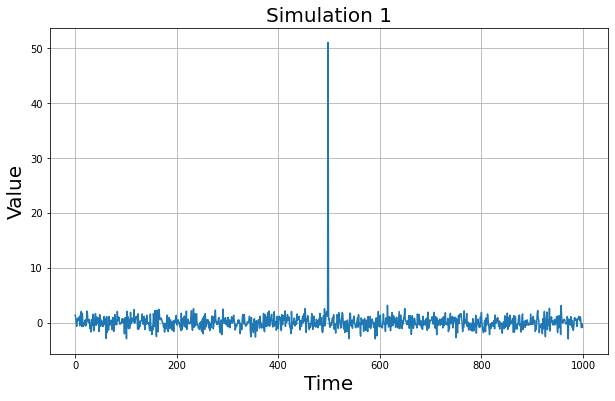

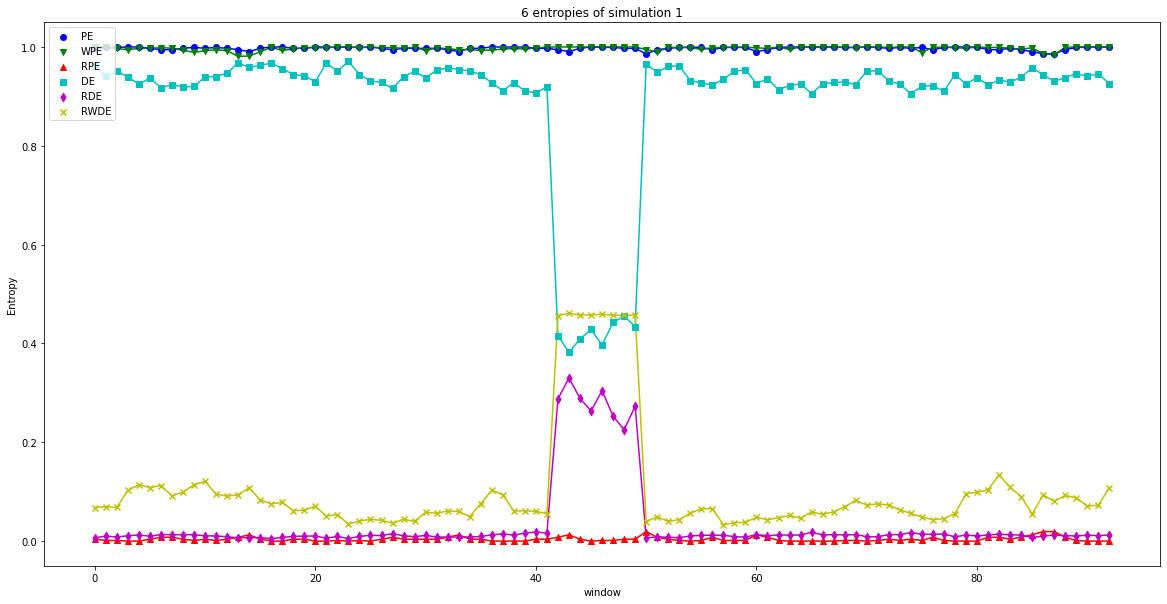

Window            41          42         43          44           45          46          47          48          49          50
--------  ----------  ----------  ---------  ----------  -----------  ----------  ----------  ----------  ----------  ----------
PE        0.997109    0.994329    0.990617   0.997109    0.999884     0.99896     0.99896     0.997109    0.997109    0.985969
WPE       0.999568    0.999914    0.999904   0.999912    0.999904     0.9999      0.999921    0.999922    0.999936    0.994406
RPE       0.00400577  0.00785131  0.0129787  0.00400577  0.000160231  0.00144208  0.00144208  0.00400577  0.00400577  0.0193879
DE        0.919312    0.415894    0.382096   0.408913    0.428367     0.396797    0.44257     0.455635    0.433995    0.965233
RDE       0.0164214   0.287697    0.330217   0.288685    0.263634     0.304507    0.252757    0.225728    0.272864    0.00653284
RWDE      0.0556617   0.456568    0.461065   0.457475    0.457645     0.459046    0.457411    0.456641  

In [67]:
order = 2
classes = 6
time = np.arange(1000)
ts = simulation1()
entropies = all_entropies(ts,80,10,order,classes)
plot_time_series(time, ts, "Simulation 1")
plot_comparison_plot(entropies,"6 entropies of simulation 1")
#print(entropies)
print_entropy_window(entropies)
print_entropy_means(entropies)

The above graph comparison on entropies shows 6 entropies in the windows from 41 to 51, as these windows contain the impulse signal. DE, RDE and RWDE have a significant variation which suggests that they were able to detect the mutation. Note that in this simulation we do not use the recommended/best embedding dimension. We want to check the ability of entropies to detect mutation signal independent of parameters.
 
For further comparison the above table shows the means of 6 entropies and their variation ratios. A is the means of 82 windows without an impulse signal, B is the means of 8 windows with an impulse signal, and the variation ratio is the ratio
of maximum to minimum of A and B. For PE, WPE and RPE the variation are very small (from 1.0004 to 1.16). For DE,RDE and RWDE there are obvious difference between A and B, the variation ratio are greater than 2 for all of them. The simulation shows that DE, RDE and RWDE can detect mutation signals.

## Simulation 2 : Entropies with recommended parameters

Based on the recommended parameters range for PE,DE and RDE we change the embedding dimension to 3 and classes(c) to 4.

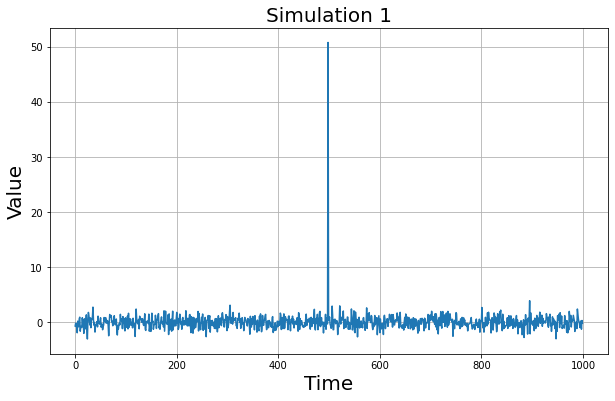

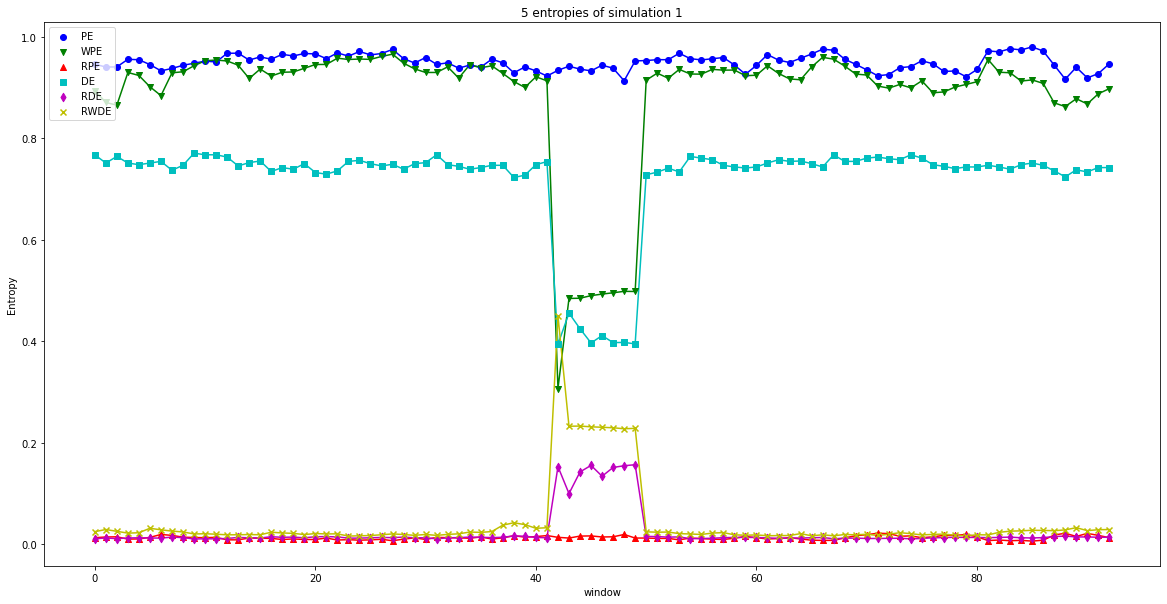

Window           41         42         43         44         45         46         47         48         49         50
--------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------
PE        0.922244   0.933417   0.941614   0.935739   0.932423   0.943588   0.93762    0.912915   0.951985   0.952734
WPE       0.912822   0.30676    0.484215   0.484631   0.489745   0.492771   0.495376   0.498192   0.497894   0.913958
RPE       0.0172402  0.0137203  0.0123124  0.0161843  0.0165363  0.0144243  0.0147763  0.0193522  0.0123124  0.0123124
DE        0.753698   0.394121   0.455315   0.42453    0.396535   0.411039   0.397224   0.397624   0.394743   0.727724
RDE       0.0128415  0.153042   0.099874   0.142544   0.155412   0.134077   0.151348   0.154735   0.156767   0.0155507
RWDE      0.0326414  0.449476   0.232511   0.23289    0.231395   0.230503   0.229499   0.227583   0.228386   0.024579
Parameters                    PE       WPE        RP

In [47]:
order = 4
classes = 4
time = np.arange(1000)
ts = simulation1()
entropies = all_entropies(ts,80,10,order,classes)
plot_time_series(time, ts, "Simulation 1")
plot_comparison_plot(entropies,"5 entropies of simulation 1")
#print(entropies)
print_entropy_window(entropies)
print_entropy_means(entropies)

### Simulation 2 : Results

The above comparison graph shows the entropy values for 6 entropies. As expected DE, RDE and RWDE were able to detect mutation signal with siginificant variation. Unlike simulation 1, WPE with the embedding dimension of three can detect the mutation signal, the simulation results show that the value of embedding dimension can affect the capability of
WPE in detecting mutation signals.   
    
The above table shows the means of the five entropies and their variation ratios. For PE and RPE, A and B are close, and the variation ratios are almost 1 (1.015 and 1.17, respectively). Under recommended parameters, WPE, DE, RDE and RWDE can detect mutation signal. RWDE with the highest variation ratio have better performance than other five entropies in detecting mutation signal.

## Simulation 3: Robustness Test   

In order to verify the robustness of RDE to noise, we carried out noise robustness testing by using the same impulse signal x in simulation 1, and the synthetic signals y with different SNRs (Signal to Noise Ratio) can be obtained by adding white Gaussian noise to x. All parameters are consistent with simulation 1. We set embedding dimension(order) to 3 and classes(c) to 6 for DE, RDE and RWDE.   



In [50]:
def get_simulation3(snr):
  time_series = np.zeros(1000)
  mean_noise = 0
  noise_variance = 10 ** (snr / 10)
  # Generate noise samples
  noise = np.random.normal(mean_noise, np.sqrt(noise_variance), 1000)
  
  time_series[498] = 50
  time_series = time_series + noise 
  return time_series

def simulation2(order,classes):
  ent_pe = np.zeros(40)
  ent_wpe = np.zeros(40)
  ent_rpe = np.zeros(40)
  ent_de = np.zeros(40)
  ent_rde = np.zeros(40)
  ent_rwde = np.zeros(40)
  i = 0
  for snr in range(100,-100,-5):
    avg_ent = []
    for j in range(0,100):
      temp = []
      time_series = get_simulation3(snr/10)
      temp.append(perm_entropy(time_series, order=order, normalize=True))
      temp.append(WPE(time_series, order=order, normalize=True))
      temp.append(RPE(time_series, order=order, normalize=True))
      temp.append(DE(time_series, order=order, classes=classes, normalize=True))
      temp.append(RDE(time_series, order=order, classes=classes, normalize=True))
      temp.append(RWDE(time_series, order=order, classes=classes, normalize=True))
      avg_ent.append(temp)
    avg_ent = np.array(avg_ent).mean(axis=0)
    ent_pe[i] = avg_ent[0]
    ent_wpe[i] = avg_ent[1]
    ent_rpe[i] = avg_ent[2]
    ent_de[i] = avg_ent[3]
    ent_rde[i] = avg_ent[4]
    ent_rwde[i] = avg_ent[5]
    i = i+1
  
  return ent_pe,ent_wpe,ent_rpe,ent_de,ent_rde,ent_rwde

def print_entropy_means(entropies):
  ent_mean = []
  labels = ['A (10dB)','B (-10dB)','Max(A,B)/Min(A,B)']
  ent_mean.append(labels)
  for i,entropy in enumerate(entropies):
    temp = []
    temp.append(entropy[len(entropy)-1])
    temp.append(entropy[0])
    temp.append(max(temp[0],temp[1])/min(temp[0],temp[1]))
    ent_mean.append(temp)
  ent_mean = zip(*ent_mean)
  print (tabulate(ent_mean, headers=["Parameters", "PE","WPE","RPE", "DE", "RDE","RWDE"])) 
    

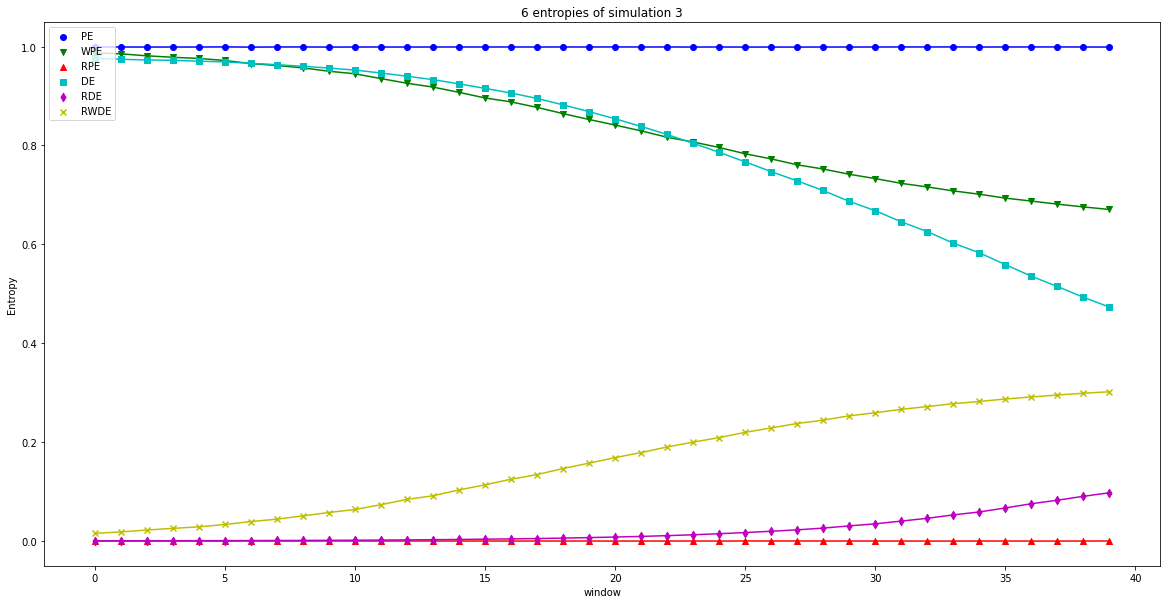

0

In [51]:
order = 3
classes = 6
entropies = simulation2(order,classes)
plot_comparison_plot(entropies,"6 entropies of simulation 3")

In [52]:
print_entropy_means(entropies)

Parameters               PE       WPE          RPE        DE          RDE        RWDE
-----------------  --------  --------  -----------  --------  -----------  ----------
A (10dB)           0.998939  0.670716  0.000760037  0.473498   0.0981843    0.302311
B (-10dB)          0.99904   0.987311  0.000686158  0.975854   0.00115328   0.0161387
Max(A,B)/Min(A,B)  1.0001    1.47203   1.10767      2.06095   85.1351      18.7321


### Simulation 3 : Results

The above graph shows 6 entropies of synthetic signal under differemt noise ratio's from -10dB to 10dB, each entropy value is the mean of 100 calculations. We can observe that the values of PE and RPE have barely changed for different SNR's and are close to 1 and 0 repectively. The values
of WPE and DE monotonically decrease with the increase of SNR; the values of RDE and RWDE monotonically increase with the increase of SNR. In this simulation we expect to observe decrease in influence of noise on complexity as the SNR increases.

For further comparison of WPE, DE, RDE and RWDE the three entropies
under −10 dB and 10 dB and their variation ratios are shown in above table. A and B are the entropies
under 10 dB and −10 dB, and Max(A, B)/Min(A, B) is the ratio of maximum to minimum of A and B.
As shown in  above Table, for WPE and RPE, there are differences between A and B, the variation ratios
are 1.472 and 1.107, respectively; RDE and RWDE has a variation ratio of  85.13 and 18.73  respectively. Therefore, the simulation results show that only DE, RDE and RWDE show significant variation. RWDE performs way better than PE, WPE, RPE and DE. However, RDE can reflect the difference better under different SNR's than RWDE and other four entropies. 


#Simulation 4 : Stability

In order to prove the stability of RWDE for synthetic signal, we carry out stability testing by using
the cosine signal of different lengths with the frequency of 100 Hz. For the five entropies, we set the
embedding dimension and time delay to three and one and set c to six for DE, RDE and RWDE.

In [48]:

def plot_simulation4(time, amplitude):
  # Plot a cosine wave using time and amplitude obtained for the cosine wave
  plt.plot(np.arange(len(amplitude)), amplitude)
  # Give a title for the cosine wave plot
  plt.title('Cosine wave')

  # Give x axis label for the cosine wave plot
  plt.xlabel('Time')
  # Give y axis label for the cosine wave plot
  plt.ylabel('Amplitude = cosine(time)')
  # Draw the grid for the graph
  plt.grid(True, which='both')
  plt.axhline(y=0, color='b')

  # Display the cosine wave plot
  plt.show()

def get_simulation4():  
  cosine = cosine_wave(frequency=10.0, samplerate=12000)
  plot_simulation4(0, cosine)
  # time = np.arange(0, 10, 0.01)
  # amplitude = np.cos(time)
  # plot_simulation4(time, amplitude)
  return cosine


def simulation4(order,classes):
  time_series = get_simulation4()
  ent_pe = np.zeros(100)
  ent_wpe = np.zeros(100)
  ent_rpe = np.zeros(100)
  ent_de = np.zeros(100)
  ent_rde = np.zeros(100)
  ent_rwde = np.zeros(100)
  i = 0 
  for sample in range(2000,12000,100):
    ent_pe[i] = perm_entropy(time_series[:sample], order=order, normalize=True)
    ent_wpe[i] = WPE(time_series[:sample], order=order, normalize=True)
    ent_rpe[i] = RPE(time_series[:sample], order=order, normalize=True)
    ent_de[i] = DE(time_series[:sample], order=order, classes=classes, normalize=True)
    ent_rde[i] = RDE(time_series[:sample], order=order, classes=classes, normalize=True)
    ent_rwde[i] = RWDE(time_series[:sample], order=order, classes=classes, normalize=True)
    i= i + 1
  return ent_pe,ent_wpe,ent_rpe,ent_de,ent_rde,ent_rwde
    
def plot_entropies(entropies):
  labels = ["PE","WPE","RPE", "DE", "RDE","RWDE"]
  for i,entropy in enumerate(entropies):
      plt.scatter(np.arange(2000,12000,100), entropy)
      plt.plot(np.arange(2000,12000,100), entropy)
      plt.title(labels[i])
      # Give x axis label for the cosine wave plot
      plt.xlabel('Sampling point')
      # Give y axis label for the cosine wave plot
      plt.ylabel('Entropy')
      # Draw the grid for the graph
      plt.grid(True, which='both')

      # Display the cosine wave plot
      plt.show()
  
def print_results(entropies):
  ent_mean = []
  labels = ['Mean','Standard Deviation']
  ent_mean.append(labels)
  for i,entropy in enumerate(entropies):
    temp = []
    temp.append(entropy.mean())
    temp.append(np.std(entropy))
    ent_mean.append(temp)
  ent_mean = zip(*ent_mean)
  print (tabulate(ent_mean, headers=["Parameters", "PE","WPE","RPE", "DE", "RDE","RWDE"])) 


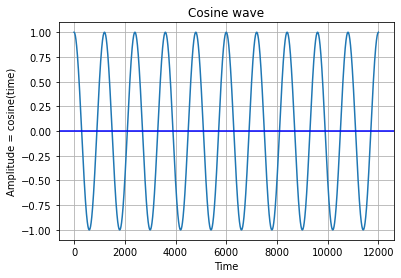

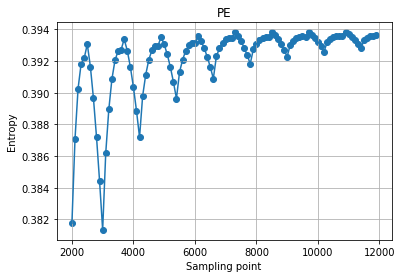

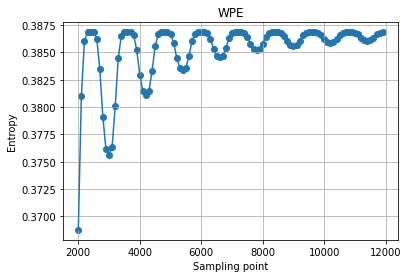

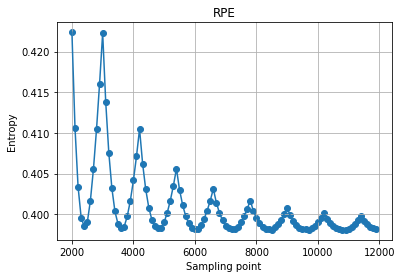

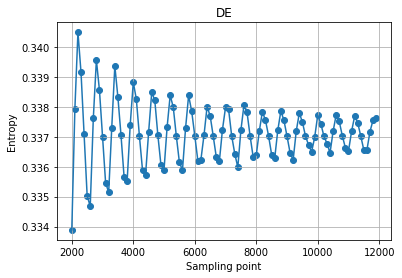

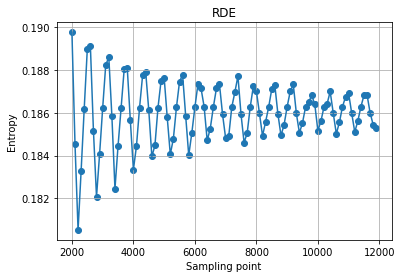

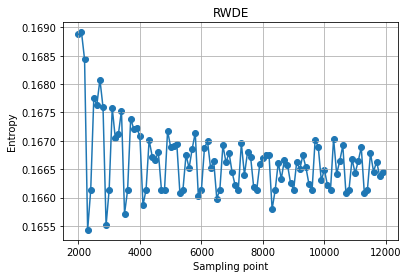

Parameters                  PE         WPE        RPE          DE         RDE         RWDE
------------------  ----------  ----------  ---------  ----------  ----------  -----------
Mean                0.392134    0.385301    0.40094    0.337115    0.186016    0.16665
Standard Deviation  0.00232472  0.00283857  0.0046018  0.00101149  0.00145295  0.000604906


In [49]:
order = 3
classes = 6
entropies = simulation4(order,classes)
plot_entropies(entropies)
print_results(entropies)

### Simulation 4 : Results

The six entropies of cosine signal (Completely deterministic and non-linear) with the frequency of 100 Hz are shown in above Figures , the initial data length is 2000 sampling points, and 100 sampling points are added each time until the data length reached 12,000 sampling points.    

We can observe that six entropies change in varying degrees with the increase of data length; the values of WPE are from 0.370 to 0.3875, the variation ranges of WPE (10-2) is of same order of magnitude as that of PE (10-2), RPE (10-2); the variation ranges of DE(10-3) and RDE (10-3) are smaller than ones of WPE. Where as the variation range of RWDE is of order (10-4). The mean and standard deviation of six entropies for the cosine signal of different lengths are shown in above Table . As shown in Table , RwDE has the smallest standard deviation compared with the other five entropies. The stability testing results indicate that RWDE have better stability than the other five entropies under different lengths of data. 